In [1]:
import numpy as np
import matplotlib.pyplot as  plt
import scipy.stats as stats
import scipy.linalg
from scipy.integrate import solve_ivp
import ot

In [2]:
def compute_gradient_U(X_samples, mu_X, Sigma_X):
    
    # Inverse of the covariance matrix
    Sigma_X_inv = np.linalg.inv(Sigma_X)
    
    # Compute the gradient for each sample
    gradients = np.dot(X_samples - mu_X, Sigma_X_inv)
    
    return gradients

# EM scheme with conditional expectation estimation (d=2)

(10000, 2, 501)
325.24350168042304
squared 2‑Wasserstein (Bures) distance = 325.53589838486226
 |E‖X_T−Y_T‖² – W₂²| = 0.4230898958988405


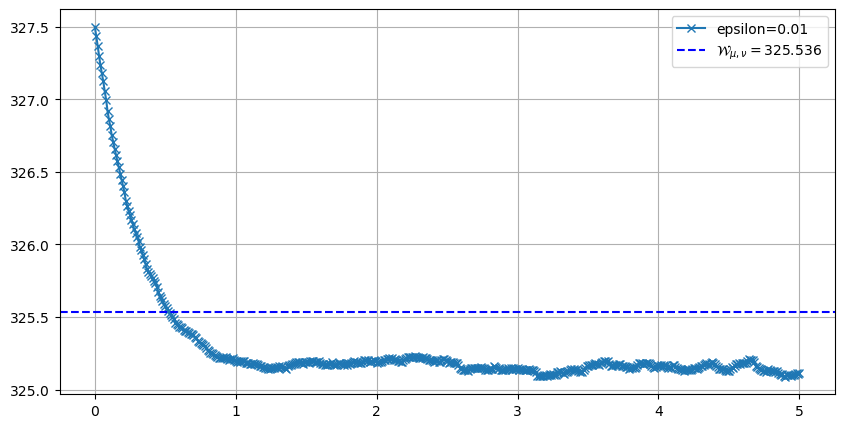

In [3]:
from conditional_expectation_methods import compute_ols_parameters, compute_conditional_mean, compute_relative_L2_error

# Set random seed for reproducibility
np.random.seed(56)

# Define parameters
num_samples = 10000
epsilon = 0.01
T = 5
d = 2

# Define parameters for X and Y
mu_X = np.array([10, 20])  # Mean of X
mu_Y = np.array([4, 3])  # Mean of Y
K_XX = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix for X
K_YY = np.array([[1, -0.5], [-0.5, 1]])  # Covariance matrix for Y
K_XY = np.array([[0.3, 0.2], [0.2, 0.3]])  # Covariance matrix between X and Y

# Generate samples from the joint distribution
mu = np.concatenate([mu_X, mu_Y])
Sigma = np.block([
    [K_XX, K_XY],
    [K_XY.T, K_YY]
])
samples = np.random.multivariate_normal(mu, Sigma, size=num_samples)

# Split the samples into X and Y
X = samples[:, :2]
Y = samples[:, 2:]

N = 500
X_traj = np.zeros((num_samples, d, N+1))
Y_traj = np.zeros((num_samples, d, N+1))
X_traj[:, :, 0] = X
Y_traj[:, :, 0] = Y

Dt = T/N

# Brownian increments for X1 and X2
W_inc = np.sqrt(Dt * 2 * epsilon) * np.random.normal(0, 1, (num_samples, d, N)) 
# Cumulative sum to get the Brownian motion paths
W = np.concatenate((np.zeros((num_samples, d, 1)), np.cumsum(W_inc, axis=2)), axis=2)
print(W.shape)

# Brownian increments for Y1 and Y2
B_inc = np.sqrt(Dt * 2 * epsilon) * np.random.normal(0, 1, (num_samples, d, N))
# Cumulative sum to get the Brownian motion paths
B = np.concatenate((np.zeros((num_samples, d, 1)), np.cumsum(B_inc, axis=2)), axis=2)
errors = np.zeros(N+1)
errors[0] = np.mean(np.sum((X - Y)**2, axis=1))

for n in range(N):
    cond_meanYX, _, _ = compute_ols_parameters(X_traj[:,:,n], Y_traj[:,:,n])
    cond_meanXY, _, _ = compute_ols_parameters(Y_traj[:,:,n], X_traj[:,:,n])
    gradU = compute_gradient_U(X_traj[:,:,n], mu_X, K_XX)
    gradV = compute_gradient_U(Y_traj[:,:,n], mu_Y, K_YY)
    
    # dW = W[:,:,n+1] - W[:,:,n]
    # dB = B[:,:,n+1] - B[:,:,n]

    X_traj[:,:,n+1] = X_traj[:,:,n] + (Y_traj[:,:,n] - cond_meanYX - epsilon*gradU)*Dt + W_inc[:,:,n]
    Y_traj[:,:,n+1] = Y_traj[:,:,n] + (X_traj[:,:,n] - cond_meanXY - epsilon*gradV)*Dt + B_inc[:,:,n]
    errors[n+1] = np.mean(np.sum((X_traj[:,:,n+1] - Y_traj[:,:,n+1])**2, axis=1))
iters  = np.linspace(0, T, N+1)

# recover the squared Gaussian Bures-Wasserstein distance
res = ot.solve_sample(X, Y, method='gaussian')
BW_dist = res.value
print(BW_dist)
# --- after the loop finishes ----------------------------------------------
# squared Bures–Wasserstein distance (closed form, independent of your samples)
def gaussian_w2_squared(mu1, Sigma1, mu2, Sigma2):
    """W2²( N(mu1,Sigma1), N(mu2,Sigma2) )."""
    diff2 = np.dot(mu1 - mu2, mu1 - mu2)           # ‖μ₁ − μ₂‖²
    S1_half   = scipy.linalg.sqrtm(Sigma1)
    inner     = S1_half @ Sigma2 @ S1_half
    cross     = scipy.linalg.sqrtm(inner)
    trace_part = np.trace(Sigma1 + Sigma2 - 2 * cross)
    return diff2 + trace_part

BW_dist = gaussian_w2_squared(mu_X, K_XX, mu_Y, K_YY)   # this is already *squared*
print("squared 2‑Wasserstein (Bures) distance =", BW_dist)

# discrepancy between the simulation at time T and the exact value
print(" |E‖X_T−Y_T‖² – W₂²| =", abs(errors[-1] - BW_dist))

plt.figure(figsize=(10, 5))
plt.plot(iters, errors, linestyle='-', marker='x', label=f'epsilon={epsilon}')
plt.axhline(y=BW_dist, color='blue', linestyle='--', label=fr'$\mathcal{{W}}_{{\mu, \nu}} = {BW_dist:.3f}$')

plt.savefig('2D_Gaussian_with_cond_expectation.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

In [5]:

fhat, coefs, A = compute_ols_parameters(X, Y)
cond_mean = compute_conditional_mean(X, mu_X, mu_Y, K_XX, K_XY)
L2_error = compute_relative_L2_error(fhat, cond_mean)
print(L2_error)

0.0066438929562507775


# Optimal Map and comparison of methods

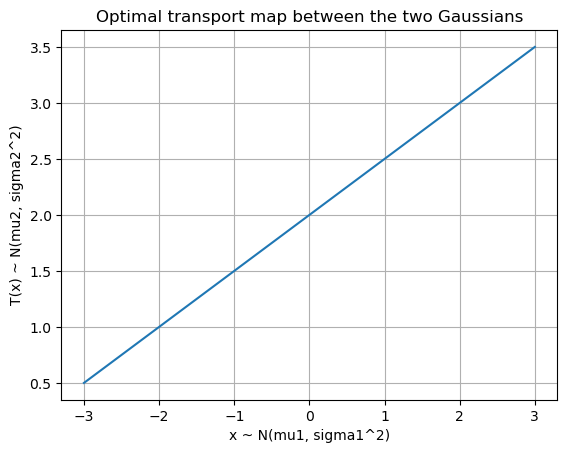

In [4]:
def T_gauss_to_gauss(x, mu1, sigma1, mu2, sigma2):
    """
    Optimal transport map pushing N(mu1, sigma1^2) to N(mu2, sigma2^2).
    """
    # Equivalent to F_target^{-1}(Φ(x)) for two Gaussians
    return mu2 + (sigma2/sigma1) * (x - mu1)

# Example usage:
mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 2.0, 0.5

# Sample some x’s from the source
x_vals = np.linspace(-3, 3, 100)
y_vals = T_gauss_to_gauss(x_vals, mu1, sigma1, mu2, sigma2)

plt.plot(x_vals, y_vals)
plt.xlabel('x ~ N(mu1, sigma1^2)')
plt.ylabel('T(x) ~ N(mu2, sigma2^2)')
plt.title('Optimal transport map between the two Gaussians')
plt.grid(True)
plt.show()

In [5]:
# --- 1) exact conditional means for the bivariate Gaussian ---
def true_E_Y_given_X(x, mu1, sigma1, mu2, sigma2, rho):
    return mu2 + rho*(sigma2/sigma1)*(x - mu1)

def true_E_X_given_Y(y, mu1, sigma1, mu2, sigma2, rho):
    return mu1 + rho*(sigma1/sigma2)*(y - mu2)


## $\varepsilon = 1^{-8}$

In [6]:
# Now you can import from cond_expect_ols.py living in that parent folder
from conditional_expectation_methods import compute_ols_parameters, nadaraya_watson, knn_conditional_expectation_improved
from wasserstein_distances import W2_empirical
from EM import euler_maruyama_coupling

def compute_gradient_U(x, mu1=0.0, sigma1=1.0):
    # x: array-like or scalar
    return (x - mu1) / (sigma1**2)

def compute_gradient_V(y, mu2=2.0, sigma2=0.5):
    return (y - mu2) / (sigma2**2)

def sample_bivariate_normal(n, mu1, sigma1, mu2, sigma2, rho, seed=None):
    """Return arrays X, Y of length n with specified Gaussian marginals
       and correlation rho."""
    rng = np.random.default_rng(seed)

    cov = np.array([[sigma1**2,        rho*sigma1*sigma2],
                    [rho*sigma1*sigma2, sigma2**2       ]])
    mean = np.array([mu1, mu2])

    samples = rng.multivariate_normal(mean, cov, size=n)
    X, Y   = samples.T
    return X, Y


# Example: X∼N(0,1), Y∼N(2,0.5²), corr=0.6
X0, Y0 = sample_bivariate_normal(
    n=1000,
    mu1=0, sigma1=1,
    mu2=2, sigma2=0.5,
    rho=0.6,
    seed=42
)

# 1. Parameters
num_samples = 1_000
epsilon     = 1e-8
T           = 20
N           = 800
k_neighbors = 10
h           = 0.01
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)
seed        = 42

# 2. Initial samples
rng = np.random.RandomState(seed)
W2_sq = W2_empirical(X0, Y0)**2
print(W2_sq) # empirical W2^2 from initial samples


# 3. OLS
errors_OLS, X_traj_OLS, Y_traj_OLS, _, mY_OLS, mX_OLS= euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='ols',     
    h=None,
    k=None,               
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq= None,
    seed=seed
)

# # 4. Isotonic regression (optional)
# errors_iso, X_traj_iso, Y_traj_iso, _, mY_iso, mX_iso= euler_maruyama_coupling(
#     X0, Y0,
#     epsilon=epsilon,
#     T=T,
#     N=N,
#     cond_method='isotonic',    
#     h=None, 
#     k=None,              
#     grad_U=compute_gradient_U,
#     grad_V=compute_gradient_V,
#     compute_W2_sq=None,
#     seed=seed
# )

# 5. Nadaraya-Watson
errors_Nad, X_traj_Nad, Y_traj_Nad, _, mY_Nad, mX_Nad = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='nadaraya',
    h=h,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# # 6. Clusters (optional)
# errs_cl, Xt_cl, Yt_cl, _ = euler_maruyama_coupling(
#     X0, Y0,
#     epsilon=epsilon,
#     T=T,
#     N=N,
#     cond_method='cluster',
#     k=k_neighbors,
#     grad_U=compute_gradient_U,
#     grad_V=compute_gradient_V,
#     compute_W2_sq=None,
#     seed=seed
# )

# 7. k-NN
errs_knn, Xt_knn, Yt_knn, _, mY_kNN, mX_kNN = euler_maruyama_coupling(
    X0, Y0,
    epsilon=epsilon,
    T=T,
    N=N,
    cond_method='knn',
    h=None,
    k=k_neighbors,
    grad_U=compute_gradient_U,
    grad_V=compute_gradient_V,
    compute_W2_sq=None,
    seed=seed
)

# errs_knn_imp, Xt_knn_imp, Yt_knn_imp, _, mY_kNNimp, mX_kNNimp = euler_maruyama_coupling(
#     X0, Y0,
#     epsilon=epsilon,
#     T=T,
#     N=N,
#     cond_method='knn_improved',
#     h=None,
#     k=k_neighbors,
#     grad_U=compute_gradient_U,
#     grad_V=compute_gradient_V,
#     compute_W2_sq=None,
#     seed=seed
# )

4.007905646967689


In [6]:
import matplotlib.pyplot as plt
mu1=0
sigma1=1
mu2=2
sigma2=0.5
rho=0.6
def true_E_Y_given_X(x, mu1, sigma1, mu2, sigma2, rho):
    return mu2 + rho*(sigma2/sigma1)*(x - mu1)

def true_E_X_given_Y(y, mu1, sigma1, mu2, sigma2, rho):
    return mu1 + rho*(sigma1/sigma2)*(y - mu2)

# temporary arrays
err_cond_kNN_Y = np.empty(N+1)
err_cond_kNN_X = np.empty(N+1)
err_cond_OLS_Y = np.empty(N+1)
err_cond_OLS_X = np.empty(N+1)
err_cond_Nad_Y = np.empty(N+1)
err_cond_Nad_X = np.empty(N+1)

for i in range(N+1):
    # use Xt_knn and Yt_knn, and the mY_kNN/mX_kNN that you unpacked
    err_cond_kNN_Y[i] = np.mean(
        (mY_kNN[i]
        - true_E_Y_given_X(
            Xt_knn[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
    err_cond_kNN_X[i] = np.mean(
        (mX_kNN[i]
        - true_E_X_given_Y(
            Yt_knn[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
    
    err_cond_OLS_Y[i] = np.mean(
        (mY_OLS[i]
        - true_E_Y_given_X(
            X_traj_OLS[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
    err_cond_OLS_X[i] = np.mean(
        (mX_OLS[i]
        - true_E_X_given_Y(
            Y_traj_OLS[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
    err_cond_Nad_Y[i] = np.mean(
        (mY_Nad[i]
        - true_E_Y_given_X(
            X_traj_Nad[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
    err_cond_Nad_X[i] = np.mean(
        (mX_Nad[i]
        - true_E_X_given_Y(
            Y_traj_Nad[i],
            mu1, sigma1,
            mu2, sigma2,
            rho
        )
        )**2
    )
# assume: errors_OLS, errors_iso, errors_Nad, errors_knn, W2_sq, T, N are already defined

t = np.linspace(0, T, N+1)

# compute normalized squared errors
rel_err_OLS    = (errors_OLS - W2_sq)**2 / W2_sq**2
# rel_err_iso    = (errors_iso - W2_sq)**2 / W2_sq**2
rel_err_Nad    = (errors_Nad - W2_sq)**2 / W2_sq**2
rel_err_knn    = (errs_knn  - W2_sq)**2 / W2_sq**2
# rel_err_cl     = (errs_cl   - W2_sq)**2 / W2_sq**2
# rel_err_knn_imp = (errs_knn_imp - W2_sq)**2 / W2_sq**2



## $\varepsilon = 1^{-3}$

In [7]:
# Example: X∼N(0,1), Y∼N(2,0.5²), corr=0.6
X0, Y0 = sample_bivariate_normal(
    n=1000,
    mu1=0, sigma1=1,
    mu2=2, sigma2=0.5,
    rho=0.6,
    seed=42
)

# 1. Parameters
num_samples = 1_000
epsilon     = 1e-3        # changed from 1e-8 to 1e-3
T           = 12
N           = 800
k_neighbors = 10
h           = 0.01
dt          = T / N
sqrt_2eps_dt = np.sqrt(2 * epsilon * dt)
seed        = 42

# 2. Initial samples
rng = np.random.RandomState(seed)
W2_sq_emp = W2_empirical(X0, Y0)**2
print("Empirical W2^2:", W2_sq_emp)

# 3. OLS
err_OLS_eps, X_OLS_eps, Y_OLS_eps, W2_OLS_eps, mY_OLS_eps, mX_OLS_eps = \
    euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='ols',
        h=None,
        k=None,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )

# 5. Nadaraya–Watson
err_NW_eps, X_NW_eps, Y_NW_eps, W2_NW_eps, mY_NW_eps, mX_NW_eps = \
    euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='nadaraya',
        h=h,
        k=None,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )

# 7. k-NN
err_kNN_eps, X_kNN_eps, Y_kNN_eps, W2_kNN_eps, mY_kNN_eps, mX_kNN_eps = \
    euler_maruyama_coupling(
        X0, Y0,
        epsilon=epsilon,
        T=T,
        N=N,
        cond_method='knn',
        h=None,
        k=k_neighbors,
        grad_U=compute_gradient_U,
        grad_V=compute_gradient_V,
        compute_W2_sq=None,
        seed=seed
    )

Empirical W2^2: 4.007905646967689


In [8]:
# Recompute conditional‐mean MSEs with the new names
err_cond_kNN_Y_eps = np.empty(N+1)
err_cond_kNN_X_eps = np.empty(N+1)
err_cond_OLS_Y_eps = np.empty(N+1)
err_cond_OLS_X_eps = np.empty(N+1)
err_cond_NW_Y_eps  = np.empty(N+1)
err_cond_NW_X_eps  = np.empty(N+1)

for i in range(N+1):
    # k-NN
    err_cond_kNN_Y_eps[i] = np.mean(
        (mY_kNN_eps[i] - true_E_Y_given_X(X_kNN_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )
    err_cond_kNN_X_eps[i] = np.mean(
        (mX_kNN_eps[i] - true_E_X_given_Y(Y_kNN_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )
    # OLS
    err_cond_OLS_Y_eps[i] = np.mean(
        (mY_OLS_eps[i] - true_E_Y_given_X(X_OLS_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )
    err_cond_OLS_X_eps[i] = np.mean(
        (mX_OLS_eps[i] - true_E_X_given_Y(Y_OLS_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )
    # Nadaraya–Watson
    err_cond_NW_Y_eps[i] = np.mean(
        (mY_NW_eps[i] - true_E_Y_given_X(X_NW_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )
    err_cond_NW_X_eps[i] = np.mean(
        (mX_NW_eps[i] - true_E_X_given_Y(Y_NW_eps[i],mu1, sigma1, mu2, sigma2, rho))**2
    )

# Recompute relative W2 errors
rel_err_OLS_eps  = (err_OLS_eps  - W2_sq_emp)**2 / W2_sq_emp**2
rel_err_NW_eps   = (err_NW_eps   - W2_sq_emp)**2 / W2_sq_emp**2
rel_err_kNN_eps  = (err_kNN_eps  - W2_sq_emp)**2 / W2_sq_emp**2

## Plot L2-error

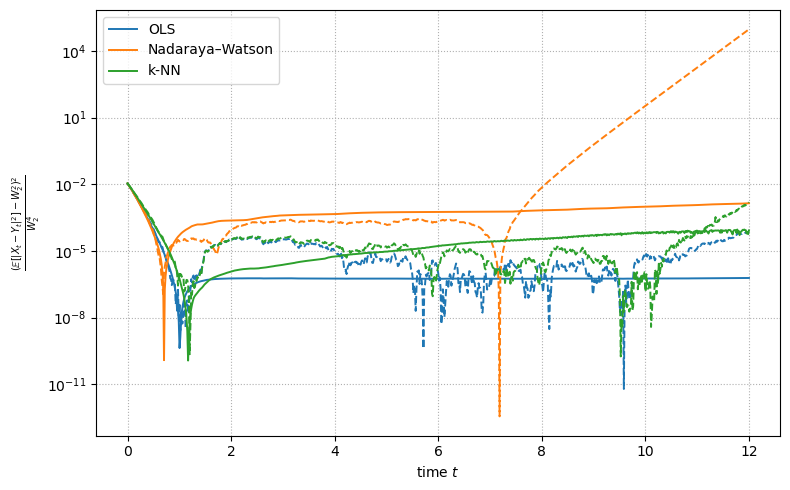

In [14]:
plt.figure(figsize=(8,5))

# OLS
l_ols, = plt.plot(t, rel_err_OLS, lw=1.4, label='OLS')
plt.plot(t, rel_err_OLS_eps, lw=1.4, linestyle='--', color=l_ols.get_color())

# Nadaraya–Watson
l_nw, = plt.plot(t, rel_err_Nad, lw=1.4, label='Nadaraya–Watson')
plt.plot(t, rel_err_NW_eps, lw=1.4, linestyle='--', color=l_nw.get_color())

# k-NN
l_knn, = plt.plot(t, rel_err_knn, lw=1.4, label='k-NN')
plt.plot(t, rel_err_kNN_eps, lw=1.4, linestyle='--', color=l_knn.get_color())

plt.xlabel(r'time $t$')
plt.ylabel(r'$\frac{(\mathbb{E}[|X_t-Y_t|^2]-W_2^2)^2}{W_2^4}$')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.savefig('L2_error_wasserstein_conditional_expectation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Conditional estimation errors

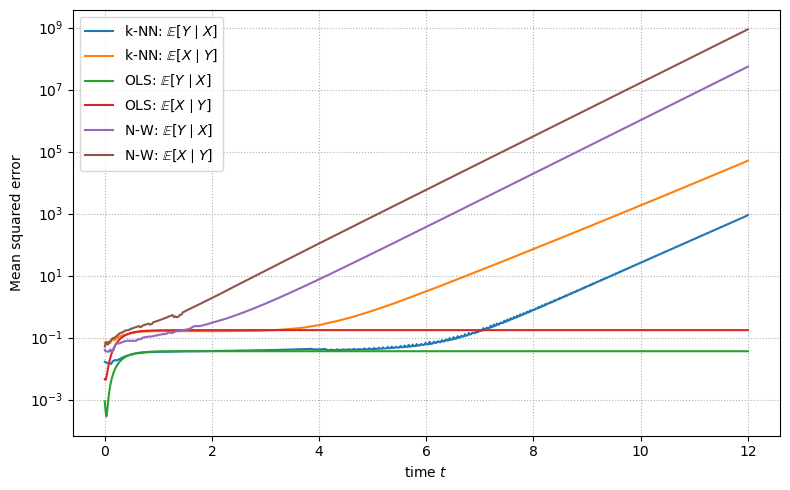

In [15]:
plt.figure(figsize=(8,5))
plt.plot(t, err_cond_kNN_Y,  lw=1.5, label=r'k-NN: $\mathbb{E}[Y\mid X]$')
plt.plot(t, err_cond_kNN_X,  lw=1.5, label=r'k-NN: $\mathbb{E}[X\mid Y]$')
plt.plot(t, err_cond_OLS_Y,  lw=1.5, label=r'OLS: $\mathbb{E}[Y\mid X]$')
plt.plot(t, err_cond_OLS_X,  lw=1.5, label=r'OLS: $\mathbb{E}[X\mid Y]$')
plt.plot(t, err_cond_Nad_Y,  lw=1.5, label=r'N-W: $\mathbb{E}[Y\mid X]$')
plt.plot(t, err_cond_Nad_X,  lw=1.5, label=r'N-W: $\mathbb{E}[X\mid Y]$')

plt.yscale('log')
plt.xlabel(r'time $t$')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.savefig('conditional_expectation_errors_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Animation and snapshots for OLS

/home/kleon/Desktop/epfl/langevinOT_sem_project/code/animations/utils.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


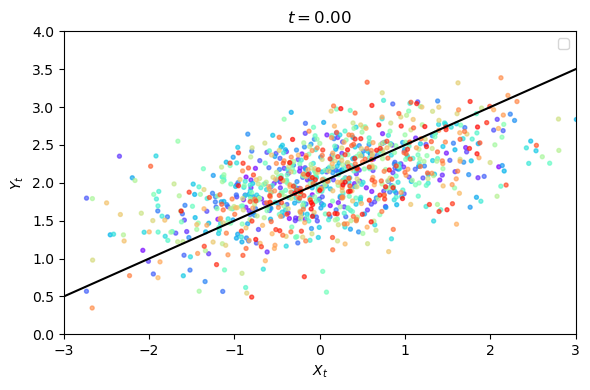

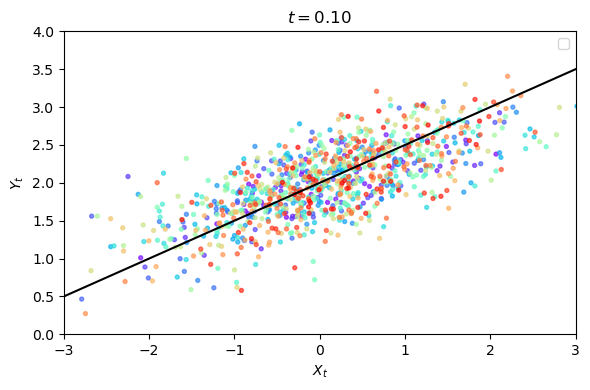

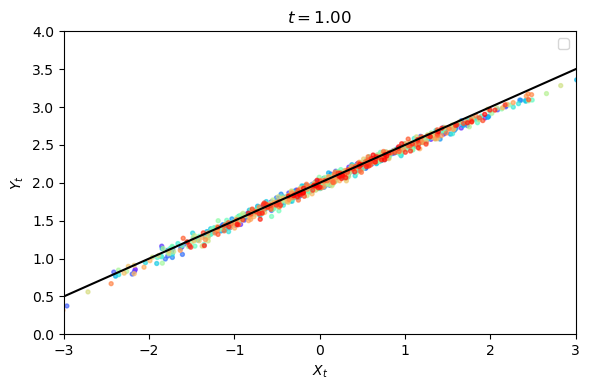

In [8]:
import numpy as np
import matplotlib.animation as animation
import os
import sys

# make sure 'animations' is on the import path
sys.path.insert(0, os.path.abspath('animations'))

from utils import animate_coupling, save_scatter_snapshot
# 1) Gaussian parameters
mu1, sigma1 = 0.0, 1.0
mu2, sigma2 = 2.0, 0.5

# 2) Define the analytic OT map for Gaussians
T_map = lambda x: mu2 + (sigma2/sigma1) * (x - mu1)

# 3) Time grid (unchanged)
t = np.linspace(0, T, N+1)

# # 4) Animate the coupling (example for the OLS run)
# ani = animate_coupling(
#     X_traj_OLS,
#     Y_traj_OLS,
#     errors_OLS,
#     t,
#     T_map,
#     filepath='coupling_with_OT_map_gauss.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# 5) Save snapshots at specific times
snapshot_times = [0.0, 0.1, 1]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=X_traj_OLS,
        Y_traj=Y_traj_OLS,
        T_map=T_map,
        filename=f'coupling_with_OT_map_gauss_snapshot_t{tau:.2f}.png'
    )


## Animation and snapshots for k-NN

Animation saved as coupling_with_OT_map_gauss_kNN.mp4


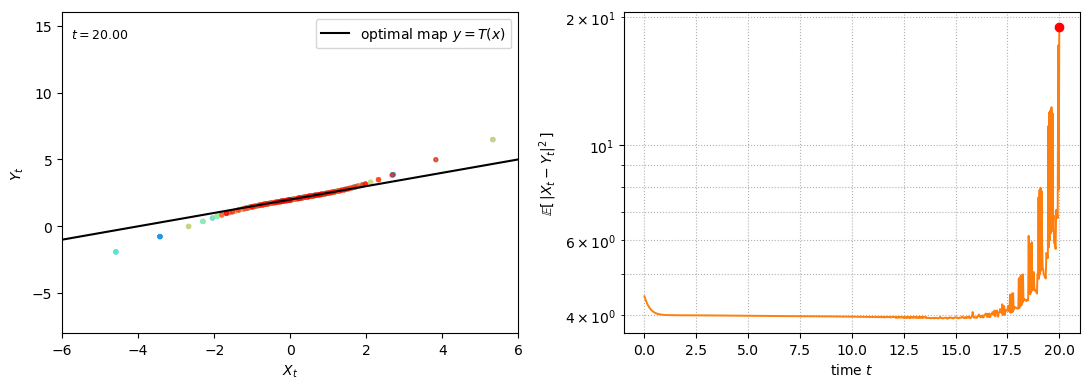

Last frame written to coupling_last_frame.png (dpi=300)


<Figure size 640x480 with 0 Axes>

NameError: name 'X_kNN_eps' is not defined

In [9]:
# 4) Animate the coupling (example for the OLS run)
ani = animate_coupling(
    Xt_knn,
    Yt_knn,
    errs_knn,
    t,
    T_map,
    filepath='coupling_with_OT_map_gauss_kNN.mp4',
    fps=15,
    interval=60,
    figsize=(11, 4),
    cmap='rainbow'
)

# 5) Save snapshots at specific times
snapshot_times = [0.0, 1, 20]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=X_kNN_eps,
        Y_traj=Y_kNN_eps,
        T_map=T_map,
        filename=f'coupling_with_OT_map_gauss_knn_snapshot_t{tau:.2f}.png'
    )


## Animation and snapshots for Nadaraya-Watson

/home/kleon/Desktop/epfl/langevinOT_sem_project/code/animations/utils.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


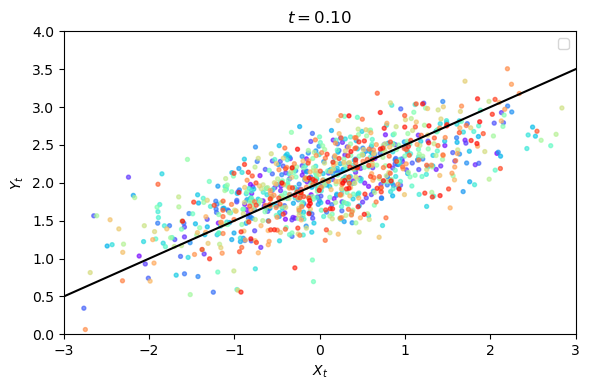

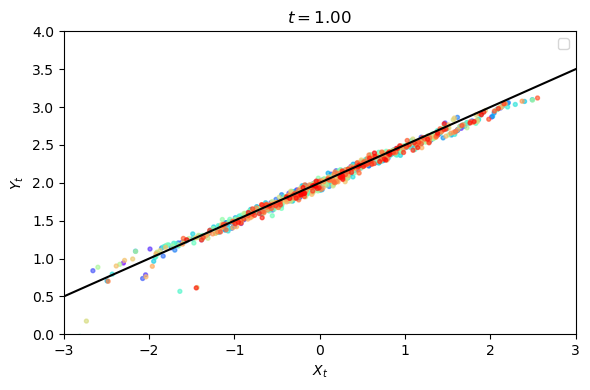

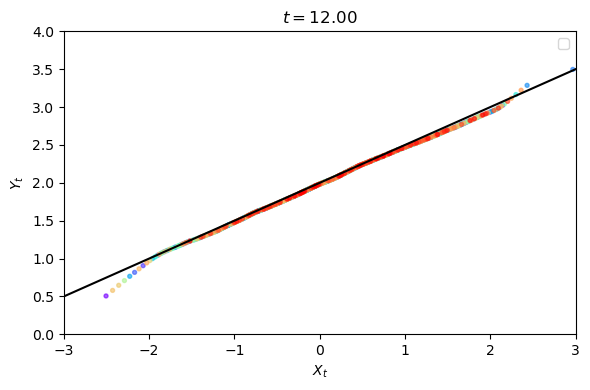

In [27]:
# # 4) Animate the coupling (example for the OLS run)
# ani = animate_coupling(
#     Xt_knn,
#     Yt_knn,
#     errs_knn,
#     t,
#     T_map,
#     filepath='coupling_with_OT_map_gauss_kNN.mp4',
#     fps=15,
#     interval=60,
#     figsize=(11, 4),
#     cmap='rainbow'
# )

# 5) Save snapshots at specific times
snapshot_times = [0.1, 1, 12]
for tau in snapshot_times:
    save_scatter_snapshot(
        time_point=tau,
        t=t,
        X_traj=X_traj_Nad,
        Y_traj=Y_traj_Nad,
        T_map=T_map,
        filename=f'coupling_with_OT_map_gauss_NW_snapshot_t{tau:.2f}.png'
    )


## Find the points furthest away from the map

In [8]:
def find_outliers_against_map(X, Y, T_map, top_k=5):
    """
    Return the top_k points (x,y) whose |y - T_map(x)| is largest.
    """
    # compute residuals
    res = np.abs(Y - T_map(X))
    # get indices of the largest top_k residuals
    idx = np.argsort(res)[-top_k:][::-1]
    # collect (x, y, residual)
    return list(zip(X[idx], Y[idx], res[idx]))

# example at final time of the k-NN run:
Xf = Xt_knn[-1]      # shape (n,)
Yf = Yt_knn[-1]

outliers = find_outliers_against_map(Xf, Yf, T_map, top_k=10)
print("Top 10 outliers (x, y, |y-T(x)|):")
for x,y,d in outliers:
    print(f" x={x:.3f}, y={y:.3f},  err={d:.3f}")

Top 10 outliers (x, y, |y-T(x)|):
 x=-3848112.230, y=-3848108.529,  err=1924054.414
 x=3493060.144, y=3493061.157,  err=1746529.085
 x=1740864.021, y=1740865.070,  err=870431.059
 x=-461382.252, y=-461378.650,  err=230689.524
 x=211020.612, y=211021.695,  err=105509.389
 x=-204493.492, y=-204489.925,  err=102245.180
 x=105152.272, y=105153.361,  err=52575.225
 x=-60886.309, y=-60882.774,  err=30441.620
 x=-60799.652, y=-60796.120,  err=30398.294
 x=52517.029, y=52518.116,  err=26257.601
